# Identifying Pneumonina using Convolutional Neural Networks

- Student Name: Kevin Spring
- Student pace: Flex
- Scheduled Project Review: January 27, 2023
- Instructor name: Morgan Jones
- Blog Post: https://medium.com/@kevinjspring/deploy-an-image-classification-model-in-minutes-with-streamlit-92e0f63b31b8

# Summary
Pneumonia is the second highest reason for admittance to a hospital in the United States. It is responsible for over 50,000 deaths in the U.S. per year. The gold standard to diagnose pneumonia is through a chest x-ray but the amount of medical imaging is increasing by 5% a year and there is a shortage of radiologists to screen the medical images. United Healthcare needs an application that can accurately classify chest x-rays as normal or pneumonia. This will reduce the costs of diagnosing pneumonia by reducing the work load for screening x-rays on radiologists. A convolutional neural network was developed using tensorflow on structured x-ray images organized into normal and pneumonia. The images were randomly sorted into training, validation, and testing datasets. The classes were weighted to account for class imbalance between the normal and pneumonia images. The data was also augmented by rotating and zooming into the images to create a larger dataset. The best model used transfer learning and has an testing accuracy of 92.2%, recall of 90.8%, and specificity of 96%. This model uses a pretrained neural network called VGG19 with a dropout layer to reduce overfitting. I deployed a web application using the python library steamlit that allows users to upload images of a chest x-ray and display the normal or pneumonia classification according to the model.

# Table of Contents

# Introduction
In the United States, pneumonia is the second most likely reason a person is admitted to a hospital, behind the birth of a child. Over 1 million adults will be admitted for pneumonia and complications each year. There are many clinical presentations of pneumonia from mild disease with limited shortness of breath and productive cough to severe disease with fever, respiratory distress, and sepsis. Due to the wide spectrum of associated clinical features, pneumonia is a one of the differential diagnosis when assessing acute respiratory illnesses.

Pneumonia will keep an inflicted person's lungs from getting enough oxygen into their blood and is caused by inflamation around the air sacs of lungs. These air sacs may be filled with fluid or pus. Infections of fungi, viruses, or bacteria, or irritation from environmental factors may lead to pneumonia. According to the Center for Disease Control and Prevention (CDC) there are 14.4 deaths caused by pneumonia per 100,000 people in the population. That is about 50,000 death a year in the United States.

Early detection is critical in preventing death due to pneumonia. According to guidelines by the American Thoracic Society and Infectious Disease Society of America, the presence of an opacity on chest imaging in a patient with a compatible clinical syndrome is the gold standard for diagnosis of pneumonia. A radiologist will interpret the x-ray and look for white spots, called infiltrates. Once diagnosed, treatment can begin to remove the excess fluid in the lungs.

## Business Problem

The Association of American Medical Colleges (AAMC) projects to have a serious shortage of radiologists by 2033, while medical images increases by about 5% a year. This will lead to worse patient outcomes as fewer radiologists need are available to make a diagnosis on an increasing number of medical images.

Our company, United Healthcare, is an medical insurance company that provides health insurance through private and Affordable Care Act (ACA) health insurance exchanges. We are expanding our coverage to more rural clients and hospitals but this is where the shortage of specialty care such as radiology is in crisis. Reducing the bottleneck in pneumonia diagnosis will reduce the time a patient is admitted to the hospital and reduce costs associated with this care.

### Project Objective

United Healthcare needs to develop an application to classify chest x-ray images with pneumonia or not (normal). Those predicted to have pneumonia would be forwarded to a radiologist for a confirmed diagnosis. This will lessen the burden and cost of radiologists reviewing chest x-rays that are not indicative of pneumonia.

## Stakeholders

- United Healthcare executives
    * Feasability and implementation of the application
- Healthcare workers
    * Users of the application

# Data
## Data Source
To find a solution to this business problem we need labeled chest x-ray images. There is a freely available dataset found on [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia), originally collected by [Kermany et al](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5), with 5,863 x-ray images in JPEG format  labeled 'val', 'test', and 'train'. Within each of those directories the images are in folders 'PNEUMONIA' or 'NORMAL'

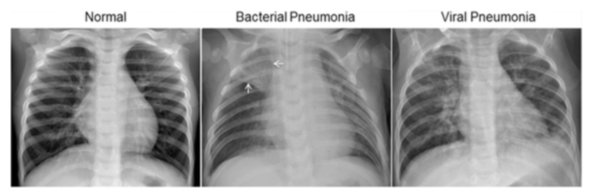

The data found in the `NORMAL` and `PNEUMONIA` folders were compiled together separately . These were then split into training and testing data using the python library [`python_splitter`](https://github.com/bharatadk/python_splitter).

In [1]:
# Unpack the data.zip from Kaggle and turn into test-train split using python_splitter
# 80% will be in training, 20% in testing

import os
# absolute path of unzipped data directory
PATH = os.path.join(os.path.abspath(os.getcwd()),'data/')

# Uncomment the lines below to install python_splitter and create the
# trian test split
#!pip install python_splitter
#from python_splitter import split_from_folder # https://github.com/bharatadk/python_splitter
#split_from_folder(PATH, train = 0.8, test=0.2)

The [cleaned data](https://drive.google.com/file/d/1__QzvDDuMxaYDhZ1o5A98Pbsk4SlUneV/view?usp=share_link) used for this analysis is available to download.

In [ ]:
# Check for class imbalance between pneumonia and normal classified images
def file_count(path, class_name):
    '''
    This helper function takes a file directory and counts
    the number of files in each subdirectory.
    '''
    import os
    dir_path = os.path.join(path, class_name + '/')
    count = 0
    for root_dir, cur_dir, files in os.walk(dir_path):
        count += len(files)
    print(f'{class_name} file count: {count}')
    return count

In [19]:
# Identify counts of each class 
normal_count = file_count(PATH, 'NORMAL')
pneumonia_count = file_count(PATH, 'PNEUMONIA')
total_count = normal_count + pneumonia_count

# Create class weights to correct for imbalance
normal_weight = total_count / (2*normal_count)
pneumonia_weight = total_count / (2*pneumonia_count)

print(f'\nClass Weights')
print(f'NORMAL weight: {normal_weight}')
print(f'PNEUMONIA weight: {pneumonia_weight}')

NORMAL file count: 1583
PNEUMONIA file count: 4273

Class Weights
NORMAL weight: 1.8496525584333543
PNEUMONIA weight: 0.6852328574771823


### Class Imbalance

The data consists of chest x-ray images of those that have pneumonia and those that do not (normal).
There is a total of 5,856 images of which 27% are in the normal class and 73% are in the pneumonia
class. This data is imbalanced and a model would be more exposed to images classified as pneumonia. This could lead to the model classifing every image in this dataset as having pneumonia and it would be 73% accurate.

I can set the class weights attribute in keras to give more wieghts to the underrepresented class. Class weights are inversely proportional to their respective frequencies. The formula to calculate the class weights is:

$$w_j = \frac{n_{j}}{{N} \times n_{j}}$$

Where,
* $w_j$ weight of class $j$
* ${N}$ is the total number of samples in all classes
* $n_{j}$ is the number of samples in class $j$

The weight attribute will tell the model to pay more attention to samples from the under-represented class, normal.

In [3]:
# Set directories for the train-test data
import os#, shutil

data_path = os.path.join(os.path.abspath(os.getcwd()),'Train_Test_Folder/')
train_dir = os.path.join(data_path, 'train/')
test_dir = os.path.join(data_path, 'test/')
train_normal = os.path.join(train_dir, 'NORMAL/')
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA/')

The images are chest x-rays with variable resolution and image size. They are in grayscale format.

In [5]:
# Import data into tensorflow Dataset object
from tensorflow.keras.utils import image_dataset_from_directory

img_height = 240
img_width = 240
grayscale = 1
batch_size = 64

train_ds, val_ds = image_dataset_from_directory(train_dir,
                                        color_mode='grayscale',
                                        label_mode='binary',
                                        validation_split=0.2,
                                        subset='both',
                                        seed=42,
                                        image_size=(img_height, img_width),
                                        batch_size = batch_size)


test_ds = image_dataset_from_directory(test_dir,
                                       color_mode='grayscale',
                                       label_mode='binary',
                                       image_size=(img_height, img_width)
                                      )

# print out the number of batches and data type
print('Batches for testing -->', test_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())
print('Batches for training -->', train_ds.cardinality())

2023-01-09 11:08:00.433256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 4684 files belonging to 2 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 2 classes.
Batches for testing --> tf.Tensor(37, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(15, shape=(), dtype=int64)
Batches for training --> tf.Tensor(59, shape=(), dtype=int64)


In [6]:
# Display tensor shape of data in tensorflow object
print(train_ds.class_names)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['NORMAL', 'PNEUMONIA']
(64, 240, 240, 1)
(64, 1)


Image number: 1266
normal picture title:  NORMAL2-IM-0661-0001.jpeg
pneumonia picture title: person1424_virus_2437.jpeg


Text(0.5, 1.0, 'Pneumonia')

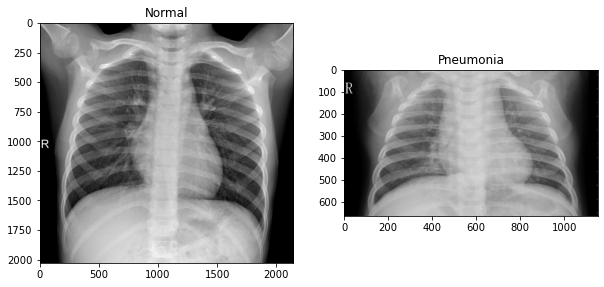

In [4]:
# Show a representative image of the data
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print(f'Image number: {len(os.listdir(train_normal))}')
rand_norm = np.random.randint(0, len(os.listdir(train_normal)))
norm_img = os.listdir(train_normal)[rand_norm]
print('normal picture title: ', norm_img)
norm_img_address = train_normal+norm_img

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_pneumonia)))

pneu_img =  os.listdir(train_pneumonia)[rand_norm]
pneu_img_address = train_pneumonia+pneu_img
print('pneumonia picture title:', pneu_img)

# Load the image
norm_load = Image.open(norm_img_address)
pneu_load = Image.open(pneu_img_address)

# Show the picture
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap='gray')
ax1.set_title('Normal')

ax2 = fig.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneu_load, cmap='gray')
ax2.set_title('Pneumonia')

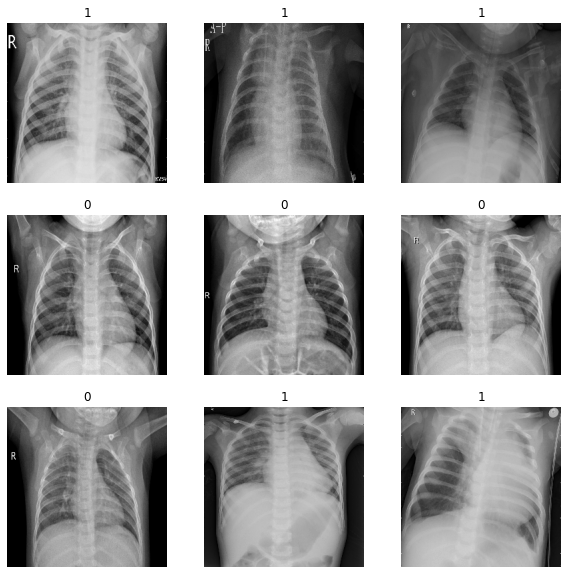

In [7]:
# Visualize the data stored in the tensorflow object
# 0 = normal
# 1 = pneumonia
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')
        plt.title(int(labels[i]))
        plt.axis('off')

In [8]:
# Configure the dataset for performance
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training the model.
# Dataset.prefetch overlaps data preprocessing and model execution while training.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modeling
Convolutional Neural Networks (CNN) is a machine learning technique that reduces the high dimensionality of data such as images without reducing its information. CNNs have outperformed other machine learning algorithms in image classification and is what I will use to train models on the x-ray image data.

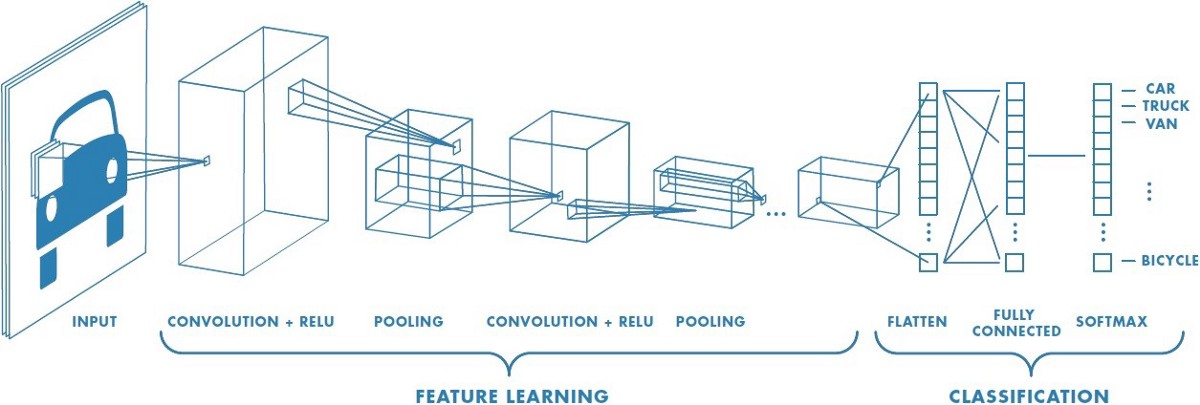

While densly connected neural networks learn global patterns in ther input feature space, convolution layers learn local paterns, that are found in 2-dimensional windows. This allows CNNs to learn patterns that are translation-invariant, something learned in one part of the image can be reused in another part. CNNs can also learn spatial heirarchies of patterns. The first layer of a CNN learns small local patterns such as edges. The next layer will learn larger patterns.

![CNN spatial hierarchies](img/spatial_hierarchy.PNG)

## Metrics Used
For our Pneumonia Classification Application to be useful it needs to be able to correctly classify pneumonia cases and limit false negatives. False negatives would be cases when the model classifies an x-ray as `normal` when the patient actually has `pneumonia`. False negatives would not be sent to a radiologist for confirmation. The metrics best to evaluate the models would be accuracy, recall, specificity, and false negative rate (FNR). We want to maximize accuracy, recall, and specificity, while minimizing the FNR.

Accuracy is a measurement of the number of correct classifications the model makes. Recall tells us what proportion of actual positives was identified correctly. Specificity is the percentage of true negatives that will test ast negative, and FNR is the rate of false negatives the model classifies.

The baseline acceptable values for each of these would be 90% for accuracy and recall, 90% for specificity, and 5% for FNR.

$$Accuracy = \frac{TP + TN}{TP+TN+FP+FN}$$

$$Recall = \frac{TP}{TP+FN}$$

$$Specificity = \frac{TN}{FP+TN}$$

$$FNR = \frac{TN}{FP+TN}$$

where
* $FN =$ Number of False Negative classified by the model
* $FP =$ Number of False Positive classified by the model
* $TN =$ Number of True Negatives
* $TP =$ Number of True Positives

In [30]:
# libraries for neural networks
import keras
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Rescaling
from keras.metrics import SpecificityAtSensitivity

In [10]:
def plot_fun(model, epochs, file_name):
    '''
    Plotting helper function.
    Plots the Training and validation accuracy
    as well as the training and validation loss
    over the number of epochs specified
    '''
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(epochs)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    #plt.figure(figsize=(12, 4))
    #plt.subplot(1, 2, 1)
    ax[0].plot(epochs_range, acc, 'g-', label='Training Accuracy')
    ax[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    ax[0].legend(loc='lower right')
    #ax[0].title('Training and Validation Accuracy')
    ax[1].title.set_text('Training and Validation Accuracy')

    #plt.subplot(1, 2, 2)
    ax[1].plot(epochs_range, loss, 'g-', label='Training Loss')
    ax[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    ax[1].legend(loc='upper right')
    ax[1].title.set_text('Training and Validation Loss')
    #ax[1].title('Training and Validation Loss')
    fig.patch.set_facecolor('white')
    plt.savefig(f'plots/{file_name}.pdf')
    plt.show()

In [47]:
def confusion_matrix_plot(ds, model, file_name):
    '''
    Confusion Matrix Plot
    Modified from https://stackoverflow.com/a/66872173/1144724
    '''
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    ds_list = list(ds)
    features = np.concatenate([ds_list[n][0] for n in range(0, len(ds_list))])
    true_id = np.concatenate([ds_list[n][1] for n in range(0, len(ds_list))])
    
    # Create pedictions
    predicted_id = model.predict(features)
    predicted_id[predicted_id > 0.5] = 1 # prediction less than 0.5 are normal (0)
    predicted_id[predicted_id < 0.5] = 0 # predictions greater than 0.5 are pneumonia (1)

    # Calculate confusion matrix
    cm_norm = confusion_matrix(true_id, predicted_id,  
                               normalize =None)
    tn, fp, fn, tp = confusion_matrix(true_id, predicted_id, labels=[0,1]).ravel()    
    
    # Make confusion matrix figure
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(1,1,1)
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(cm_norm, annot=True, annot_kws={"size": 12},
         cbar = False, cmap='Greens', fmt='g');
    ax1.set_ylabel('True Values',fontsize=14)
    ax1.set_xlabel('Predicted Values',fontsize=14)
    plt.grid(False)
    plt.savefig(f'plots/{file_name}.pdf')
    plt.show()
    
    # Print validation metrics
    print('Metrics')
    print(f'Accuracy: {(tp+tn)/(tp+tn+fp+fn)*100:,.2f}%')
    print(f'Recall: {tp/(tp+fn)*100:,.2f}%')
    print(f'Specificity: {tn/(tn+fp)*100:,.2f}%')
    print(f'False Negative Rate: {fn/(fn+tp)*100:,.2f}%')
    

## Model 1: Baseline model
This model implements a simple CNN first. It rescales the the pixel data within the image to have a value between 0 and 1. It has a single CNN layer and then downsizes the output through a max pooling layer. That is then flattened and put into a dense layer with one output. This output is the classification of whether the image is classified as pneumonia (1) or normal (0).

In [14]:
#import tensorflow.keras import layers

batch_size = 64
learning_rate = 0.001
epochs = 30

# Baseline model
inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs) # Rescale each pixel to 0-1
x = Conv2D(filters=32, kernel_size=3, activation='relu')(x) # CNN layer
x = MaxPooling2D(pool_size=2)(x)
# Dense Layer and flatten to produce one output
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model_baseline = keras.Model(inputs=inputs, outputs=outputs, name='baseline_model')

# Compile the Neural network
model_baseline.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.9),
                                   keras.metrics.SensitivityAtSpecificity(0.9)])

# Summary
model_baseline.summary()

# Save model at best point
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/baseline_model.keras',
        save_best_only=True,
        monitor='val_loss')
        ]

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 1)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 240, 240, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 238, 238, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 119, 119, 32)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 453152)            0         
                                                                 
 dense_4 (Dense)             (None, 1)                 453153    
                                                    

In [17]:
# Fit model
class_weights = {0: normal_weight,
                1: pneumonia_weight}

model_baseline_fit = model_baseline.fit(train_ds,
                                         epochs=epochs,
                                         validation_data = val_ds,
                                         batch_size=batch_size,
                                         callbacks=callbacks,
                                         class_weight=class_weights)

Epoch 1/30
59/59 [==============================] - 27s 370ms/step - loss: 0.4050 - accuracy: 0.8204 - recall: 0.8237 - specificity_at_sensitivity: 0.6833 - sensitivity_at_specificity: 0.7137 - val_loss: 0.3359 - val_accuracy: 0.8622 - val_recall: 0.8159 - val_specificity_at_sensitivity: 0.9675 - val_sensitivity_at_specificity: 0.9536
Epoch 2/30
59/59 [==============================] - 21s 351ms/step - loss: 0.1842 - accuracy: 0.9317 - recall: 0.9293 - specificity_at_sensitivity: 0.9588 - sensitivity_at_specificity: 0.9611 - val_loss: 0.2294 - val_accuracy: 0.9060 - val_recall: 0.8768 - val_specificity_at_sensitivity: 0.9797 - val_sensitivity_at_specificity: 0.9783
Epoch 3/30
59/59 [==============================] - 20s 337ms/step - loss: 0.1410 - accuracy: 0.9466 - recall: 0.9446 - specificity_at_sensitivity: 0.9745 - sensitivity_at_specificity: 0.9732 - val_loss: 0.1158 - val_accuracy: 0.9583 - val_recall: 0.9725 - val_specificity_at_sensitivity: 0.9878 - val_sensitivity_at_specifici

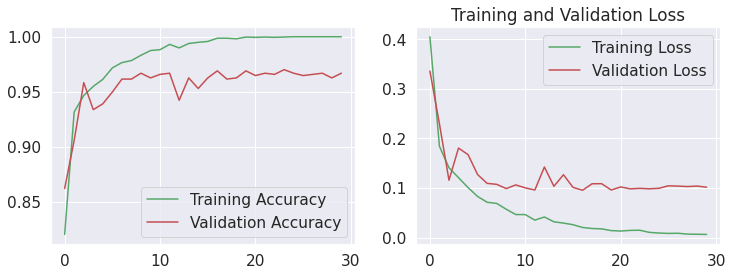

30/30 [==============================] - 1s 42ms/step


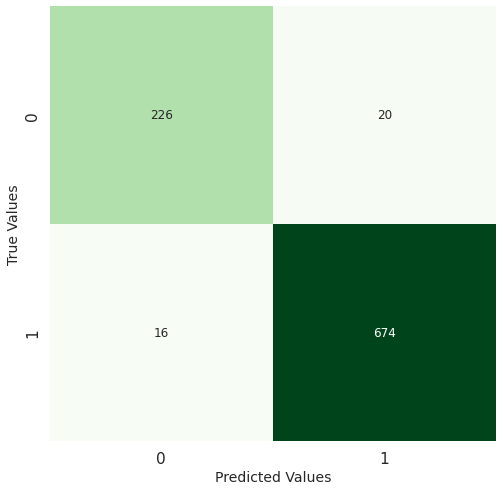

Metrics
Accuracy: 96.15%
Recall: 97.68%
Specificity: 91.87%
False Negative Rate: 2.32%


In [51]:
epochs = 30
plot_fun(model_baseline_fit, epochs, 'baseline_model_plot_accuracy')
confusion_matrix_plot(val_ds, model_baseline, 'baseline_model_confusion_matrix_val')

### Discussion of model 1

According to the validation dataset, the baseline model did very well in classifying the normal and pneumonia x-ray images. Accuracy and specificity is above the acceptable level of 90%. I may be able to improve upon the baseline model by adding more layers, but it is possible this will increase overfitting because of the small amout of data images.

The false negative rate is below 5% which meets my cutoff I set for acceptance but it may be possible to reduce this value futher. Missing these cases would not be reviewed by a radiologists for confirmation. I want to reduce this value as much as possible without sacrificing accuracy and recall.

## Model 2
The baseline model is extremely good and beats our required metric of 90% for accuracy and below the 5% threshold I set for false negatives. It is possible to improve on these metrics by modifying some settings and increasing layers, but we need to be careful about overfitting as I have a small dataset. The second model increases the number of layers in the CNN from one to three.

In [21]:
# Model 2
inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
# First CNN Layer
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2, padding='same')(x)
# Second CNN Layer
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2, padding='same')(x)
# Third CNN layer
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2, padding='same')(x)
# Dense Layer and flatten to produce one output
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs, name='model_2')

# Compile the Neural network
model2.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.9),
                                   keras.metrics.SensitivityAtSpecificity(0.9)])

# Summary
model2.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model2.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 1)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 240, 240, 1)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 240, 240, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 120, 120, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 60, 60, 64)       0         
 g2D)                                                      

In [22]:
# Fit model
epochs=30
model2_fit = model2.fit(train_ds,
                        steps_per_epoch=len(train_ds),
                        epochs=epochs,
                        validation_data = val_ds,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        class_weight=class_weights,
                        verbose=1)

Epoch 1/30
59/59 [==============================] - 91s 2s/step - loss: 0.4264 - accuracy: 0.8135 - recall_2: 0.8215 - specificity_at_sensitivity_2: 0.6833 - sensitivity_at_specificity_2: 0.6851 - val_loss: 0.2338 - val_accuracy: 0.9092 - val_recall_2: 0.9014 - val_specificity_at_sensitivity_2: 0.9309 - val_sensitivity_at_specificity_2: 0.9232
Epoch 2/30
59/59 [==============================] - 96s 2s/step - loss: 0.1929 - accuracy: 0.9224 - recall_2: 0.9223 - specificity_at_sensitivity_2: 0.9441 - sensitivity_at_specificity_2: 0.9417 - val_loss: 0.2275 - val_accuracy: 0.9049 - val_recall_2: 0.8754 - val_specificity_at_sensitivity_2: 0.9756 - val_sensitivity_at_specificity_2: 0.9710
Epoch 3/30
59/59 [==============================] - 90s 2s/step - loss: 0.1579 - accuracy: 0.9389 - recall_2: 0.9366 - specificity_at_sensitivity_2: 0.9618 - sensitivity_at_specificity_2: 0.9681 - val_loss: 0.2239 - val_accuracy: 0.9071 - val_recall_2: 0.8812 - val_specificity_at_sensitivity_2: 0.9797 - val

Epoch 25/30
59/59 [==============================] - 87s 1s/step - loss: 0.0798 - accuracy: 0.9699 - recall_2: 0.9674 - specificity_at_sensitivity_2: 0.9961 - sensitivity_at_specificity_2: 0.9912 - val_loss: 0.1577 - val_accuracy: 0.9541 - val_recall_2: 0.9623 - val_specificity_at_sensitivity_2: 0.9756 - val_sensitivity_at_specificity_2: 0.9710
Epoch 26/30
59/59 [==============================] - 91s 2s/step - loss: 0.0233 - accuracy: 0.9923 - recall_2: 0.9919 - specificity_at_sensitivity_2: 1.0000 - sensitivity_at_specificity_2: 1.0000 - val_loss: 0.1878 - val_accuracy: 0.9466 - val_recall_2: 0.9710 - val_specificity_at_sensitivity_2: 0.9715 - val_sensitivity_at_specificity_2: 0.9652
Epoch 27/30
59/59 [==============================] - 91s 2s/step - loss: 0.0157 - accuracy: 0.9947 - recall_2: 0.9941 - specificity_at_sensitivity_2: 1.0000 - sensitivity_at_specificity_2: 0.9993 - val_loss: 0.1879 - val_accuracy: 0.9551 - val_recall_2: 0.9609 - val_specificity_at_sensitivity_2: 0.9756 - 

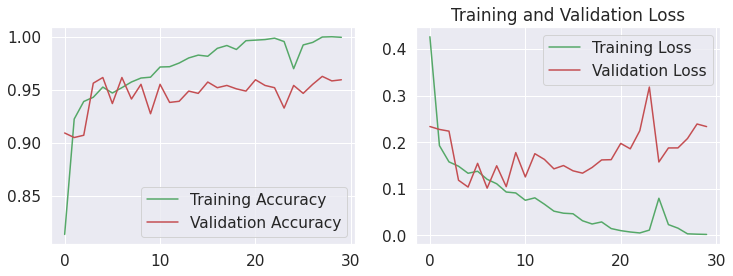

30/30 [==============================] - 6s 205ms/step


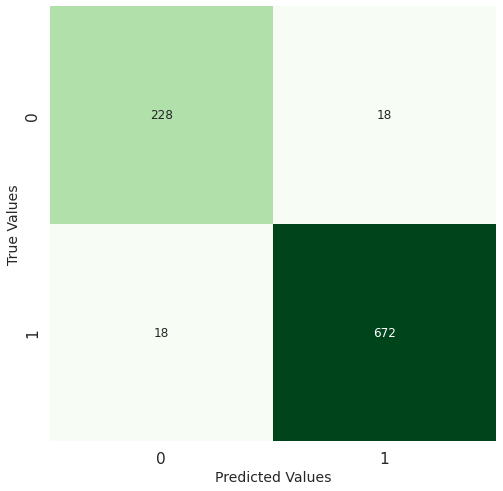

Metrics
Accuracy: 96.15%
Recall: 97.39%
Specificity: 92.68%
False Negative Rate: 2.61%


In [52]:
plot_fun(model2_fit, epochs, 'model_2_accuracy')
confusion_matrix_plot(val_ds, model2, 'model_2_val_confusion_matrix')

## Discussion
Model 2 has similar validation metrics compared to model 1 without any improvement. Another possible way to reduce overfitting is to add a dropout layer. This will randomly select which neurons to keep for the model when fitting the training data. The next goal is to maximize generalization performance with regularization.

## Model 3
Model 3 includes a dropout layer. A dropout layer will randomly drop some of the weights propogated in the neural network. The random dropout force the network to learn patterns that are useful for general regularization and avoid overfitting.

In [75]:
# Model 3
# Include a dropout
from keras.layers import Dropout

#learning_rate = 0.001
#batch_size=32

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
# First CNN layer
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
# Second CNN layer
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
# Third CNN layer
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2, padding='same')(x)
# Dense Layer and flatten to produce one output
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
# Dropout
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs, name='model_3')

# Compile the Neural network
model3.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.9),
                                   keras.metrics.SensitivityAtSpecificity(0.9)])

# Summary
model3.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model3.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 240, 240, 1)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 240, 240, 1)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 240, 240, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 120, 120, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 60, 60, 64)       0         
 g2D)                                                      

In [76]:
# Fit model
epochs=40
model3_fit = model3.fit(train_ds,
                        #steps_per_epoch=len(train_ds),
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         class_weight=class_weights)

Epoch 1/40
59/59 [==============================] - 91s 2s/step - loss: 0.4612 - accuracy: 0.7700 - recall_6: 0.7599 - specificity_at_sensitivity_6: 0.6098 - sensitivity_at_specificity_6: 0.5825 - val_loss: 0.2146 - val_accuracy: 0.9113 - val_recall_6: 0.9377 - val_specificity_at_sensitivity_6: 0.9065 - val_sensitivity_at_specificity_6: 0.9014
Epoch 2/40
59/59 [==============================] - 91s 2s/step - loss: 0.2120 - accuracy: 0.9189 - recall_6: 0.9157 - specificity_at_sensitivity_6: 0.9373 - sensitivity_at_specificity_6: 0.9351 - val_loss: 0.1415 - val_accuracy: 0.9530 - val_recall_6: 0.9594 - val_specificity_at_sensitivity_6: 0.9756 - val_sensitivity_at_specificity_6: 0.9667
Epoch 3/40
59/59 [==============================] - 96s 2s/step - loss: 0.1865 - accuracy: 0.9285 - recall_6: 0.9307 - specificity_at_sensitivity_6: 0.9431 - sensitivity_at_specificity_6: 0.9534 - val_loss: 0.1731 - val_accuracy: 0.9327 - val_recall_6: 0.9188 - val_specificity_at_sensitivity_6: 0.9756 - val

Epoch 25/40
59/59 [==============================] - 93s 2s/step - loss: 0.0254 - accuracy: 0.9899 - recall_6: 0.9879 - specificity_at_sensitivity_6: 1.0000 - sensitivity_at_specificity_6: 0.9996 - val_loss: 0.2057 - val_accuracy: 0.9530 - val_recall_6: 0.9493 - val_specificity_at_sensitivity_6: 0.9837 - val_sensitivity_at_specificity_6: 0.9754
Epoch 26/40
59/59 [==============================] - 93s 2s/step - loss: 0.0272 - accuracy: 0.9885 - recall_6: 0.9883 - specificity_at_sensitivity_6: 1.0000 - sensitivity_at_specificity_6: 0.9996 - val_loss: 0.1709 - val_accuracy: 0.9519 - val_recall_6: 0.9580 - val_specificity_at_sensitivity_6: 0.9837 - val_sensitivity_at_specificity_6: 0.9710
Epoch 27/40
59/59 [==============================] - 92s 2s/step - loss: 0.0191 - accuracy: 0.9923 - recall_6: 0.9919 - specificity_at_sensitivity_6: 1.0000 - sensitivity_at_specificity_6: 1.0000 - val_loss: 0.1557 - val_accuracy: 0.9530 - val_recall_6: 0.9623 - val_specificity_at_sensitivity_6: 0.9797 - 

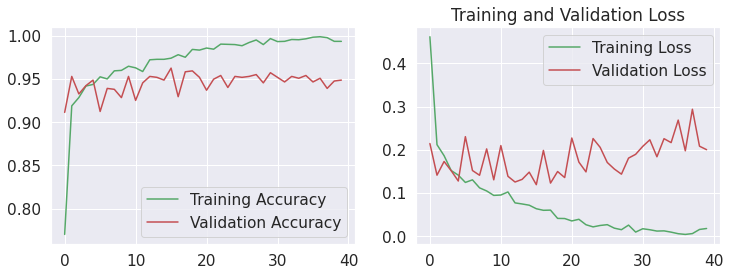

30/30 [==============================] - 6s 207ms/step


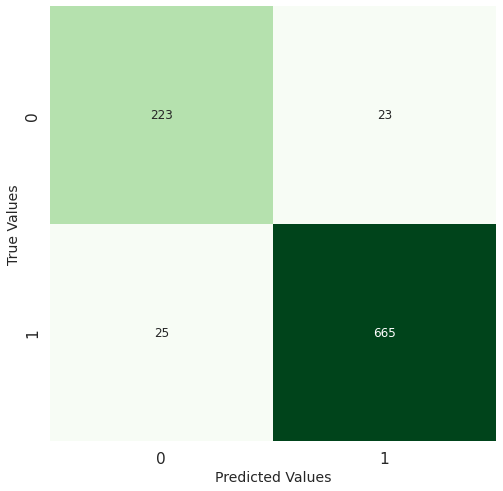

Metrics
Accuracy: 94.87%
Recall: 96.38%
Specificity: 90.65%
False Negative Rate: 3.62%


In [77]:
epochs=40
plot_fun(model3_fit, epochs, 'model_3_accuracy')
confusion_matrix_plot(val_ds, model3, 'model_3_val_confusion_matrix')

## Model 3 discussion

Althought a dropout layer was added, the metrics for model 3 are slightly worse or nearly identical to models 1 and 2 in regards to specificity, but better in accuracy and recall. 

Another solution to improve metrics is to have more data. I can use a process called data augmentation to slightly modify the images we currently have by rotating them, flipping them, and zooming into them to create many more images. This will increase the dataset we have available which may reduce overfitting.

## Model 4: CNN with data augmentation
Data augmentation is a process to take the original training dataset and slightly modify the data. The image will be randomly rotated, zoomed in and out, and flipped horizontally. This adds some variance in each image and increases the amount of data used to train the model. By increasing the camount of data we should be able to reduce overfitting because overfitting is caused by having too few samples to learn from. Given an infinite amount of data the model would learn every part of the data distrivbution and never overfit.

In [125]:
# Model 4: Data augmentationl

learning_rate = 0.001

from keras import layers

data_augmentation = Sequential(
        [
            layers.RandomFlip('horizontal'), # apply flipping to a random 50% of images
            layers.RandomRotation(0.05), # rotate images by a random value between [-5 to 5%]
            layers.RandomZoom(0.2), # zoom in and out by range [-20 to 20%]
        ])

from keras.layers import Dropout

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs, training=True)
# Rescale
x = Rescaling(1./255)(x)
# CNN layers
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
# Dense layer and flatten
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
# Dropout
x = Dropout(0.5)(x)
# Output
outputs = Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs, name='model_4')

# Compile the Neural network
model4.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.9),
                                   keras.metrics.SensitivityAtSpecificity(0.9)])

# Summary
model4.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model4.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 240, 240, 1)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 240, 240, 1)       0         
                                                                 
 rescaling_14 (Rescaling)    (None, 240, 240, 1)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 240, 240, 32)      320       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 120, 120, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 120, 120, 64)      18496     
                                                           

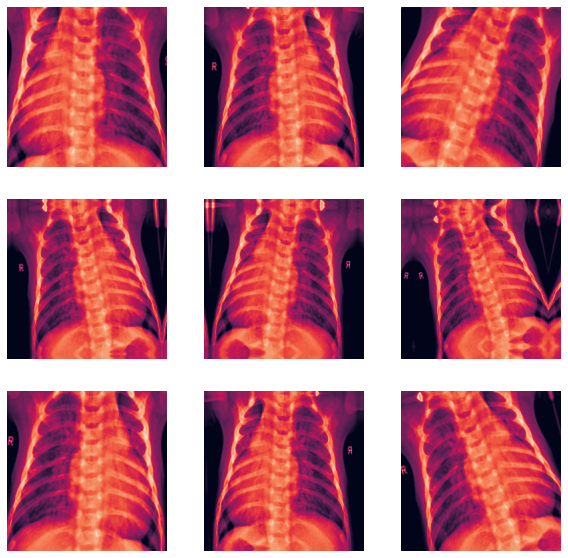

In [126]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax=plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [127]:
# Fit model
epokchs = 30
model4_fit = model4.fit(train_ds,
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         class_weight=class_weights)

Epoch 1/30


59/59 [==============================] - ETA: 0s - loss: 0.5893 - accuracy: 0.6214 - recall_20: 0.5682 - specificity_at_sensitivity_20: 0.3804 - sensitivity_at_specificity_20: 0.4025WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


59/59 [==============================] - 113s 2s/step - loss: 0.5893 - accuracy: 0.6214 - recall_20: 0.5682 - specificity_at_sensitivity_20: 0.3804 - sensitivity_at_specificity_20: 0.4025 - val_loss: 0.4737 - val_accuracy: 0.8088 - val_recall_20: 0.7652 - val_specificity_at_sensitivity_20: 0.7602 - val_sensitivity_at_specificity_20: 0.8014
Epoch 2/30
59/59 [==============================] - 111s 2s/step - loss: 0.3391 - accuracy: 0.8674 - recall_20: 0.8677 - specificity_at_sensitivity_20: 0.8176 - sensitivity_at_specificity_20: 0.8398 - val_loss: 0.2788 - val_accuracy: 0.8889 - val_recall_20: 0.9362 - val_specificity_at_sensitivity_20: 0.8455 - val_sensitivity_at_specificity_20: 0.8710
Epoch 3/30
59/59 [==============================] - 109s 2s/step - loss: 0.2722 - accuracy: 0.8941 - recall_20: 0.8937 - specificity_at_sensitivity_20: 0.8882 - sensitivity_at_specificity_20: 0.8908 - val_loss: 0.2413 - val_accuracy: 0.8953 - val_recall_20: 0.9609 - val_specificity_at_sensitivity_20: 0.8

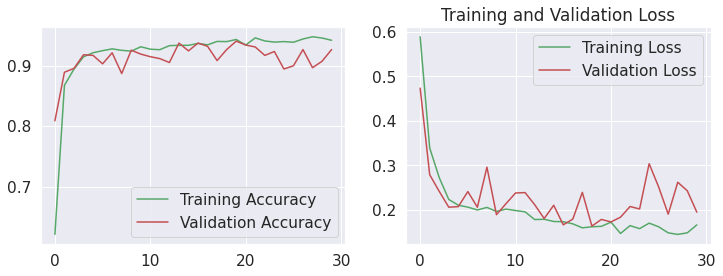

30/30 [==============================] - 10s 303ms/step


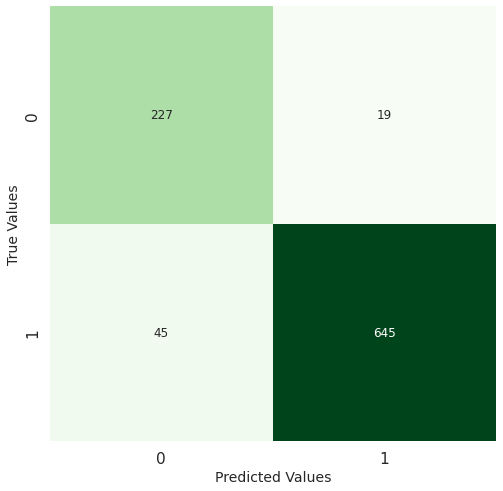

Metrics
Accuracy: 93.16%
Recall: 93.48%
Specificity: 92.28%
False Negative Rate: 6.52%


In [128]:
epochs=30
plot_fun(model4_fit, epochs, 'model_4_accuracy')
confusion_matrix_plot(val_ds, model4, 'model_4_confusion_matrix')

### Discussion

Data augmentation produces more images by zooming and rotating the current images in the dataset. This will increase the amount of data when training the models and may reduce overfitting. Data augmentation can only remix existing information so it cannot completely remove overfitting. This model has worse validation metrics than the previous models althougth accuracy, recall, and specificity is still over the 


I may be able to improve on model 4 by using transfer learning with a pre-trained model, VGG19. These are models that have been trained on millions of images for image detection and classification.

## Model 5

A common approach to deep learning with small datasets is to use a pretrained model.  pretrained model is one that has been classified on a large sample of data. The features learned by a pretrained model can acts as a generic model and can be useful for other computer vision problems. I will use a VGG19 model. The VGG19 pretrained model is a CNN that is 19 layers deep and has been trained on over one million from the ImageNet database. VGG19 is a variant of VGG model which consists of 19 layers, 16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer. By setting `include_top` to `False` the 3 fully-connected layers at the top of the network will not be included. The included layers of VGG19 will not be trained on the new data so that their weights will be kept to take advantage of transfer learning. After VGG19, the model will have a convolutional layer, max pooling, be flattened, and go to a dense layer and dropout layer as in the previous models. Thisi will fine tune the model toward the x-ray data.

In [98]:
# Model with transfer learning
from keras.applications import VGG19

# Initiate the pretrained model VGG19
conv_base = VGG19(weights='imagenet',
                 include_top=False, # Removes last 3 layers in VGG19
                                    # Will add new layers to fine tune
                 input_shape=(img_height, img_width, 3))

# freeze all layers
conv_base.trainable = False

conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [99]:
# Model 5
# With a pretrained model

learning_rate = 0.001 #5e-4

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs)
#x = Rescaling(1./255)(x) # Rescaling causes the accuracy to drop considerably so removed
x = Conv2D(3,(3,3), padding='same')(x)
x = keras.applications.vgg19.preprocess_input(x) # This must do rescaling as the model never converges
                                                 # when using rescaling above
x = conv_base(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs, outputs, name='model_5')

# Compile
model5.compile(loss='binary_crossentropy',
               optimizer=keras.optimizers.Adam(learning_rate),
               metrics = ['accuracy', 
                           keras.metrics.Recall(),
                           keras.metrics.SpecificityAtSensitivity(0.9),
                           keras.metrics.SensitivityAtSpecificity(0.9)])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/m5.keras',
        save_best_only=True,
        monitor='val_loss')
]

In [100]:
#batch_size = 32
epochs = 30
model5_fit = model5.fit(train_ds,
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         class_weight=class_weights)

Epoch 1/30


59/59 [==============================] - 1349s 23s/step - loss: 15.4132 - accuracy: 0.8263 - recall_14: 0.8251 - specificity_at_sensitivity_14: 0.6863 - sensitivity_at_specificity_14: 0.0000e+00 - val_loss: 5.6367 - val_accuracy: 0.9177 - val_recall_14: 0.9261 - val_specificity_at_sensitivity_14: 0.9024 - val_sensitivity_at_specificity_14: 0.9246
Epoch 2/30
59/59 [==============================] - 1358s 23s/step - loss: 6.1667 - accuracy: 0.8935 - recall_14: 0.8937 - specificity_at_sensitivity_14: 0.8892 - sensitivity_at_specificity_14: 0.8853 - val_loss: 6.7880 - val_accuracy: 0.8793 - val_recall_14: 0.8464 - val_specificity_at_sensitivity_14: 0.8577 - val_sensitivity_at_specificity_14: 0.8609
Epoch 3/30
59/59 [==============================] - 1354s 23s/step - loss: 4.4821 - accuracy: 0.8989 - recall_14: 0.8977 - specificity_at_sensitivity_14: 0.8980 - sensitivity_at_specificity_14: 0.8988 - val_loss: 3.9840 - val_accuracy: 0.9145 - val_recall_14: 0.9014 - val_specificity_at_sensitiv

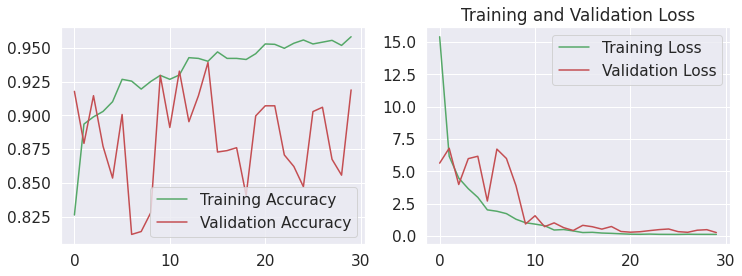

30/30 [==============================] - 123s 4s/step


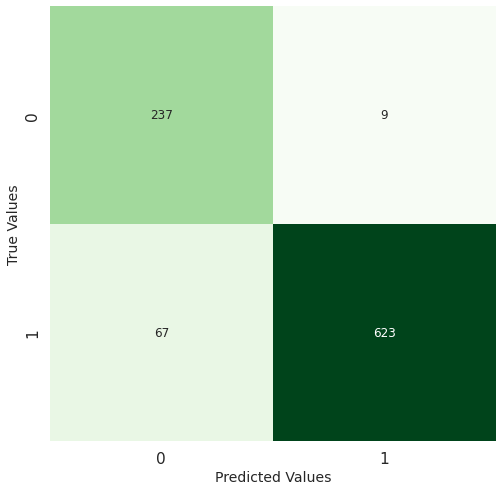

Metrics
Accuracy: 91.88%
Recall: 90.29%
Specificity: 96.34%
False Negative Rate: 9.71%


In [101]:
#model_5 = keras.models.load_model('models/keras/m5.keras')
epochs=30
plot_fun(model5_fit, epochs, 'model_5_accuracy')
confusion_matrix_plot(val_ds, model5, 'model_5_confusion_matrix')

### Discussion: Model 5
Transfer learning by using the pre-trained model VGG19 has reduced the false positive rate to the smallest amount so far in this analysis, beating models 1-4. Accuracy and recall has also improved above of model 4 and is above the 90% cut-off but still below models 1, 2, and 3.

In [130]:
# Model 6
# With a pretrained model and unfreeze 

# Initiate the pretrained model VGG19
conv_base = VGG19(weights='imagenet',
                 include_top=False, # Removes last 3 layers in VGG19
                                    # Will add new layers to fine tune
                 input_shape=(img_height, img_width, 3))

# freeze all layers
conv_base.trainable = False

# model 6
learning_rate = 0.001 #5e-4

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs, training=True)
x = Rescaling(1./255)(x) # Rescaling causes the accuracy to drop considerably so removed
x = Conv2D(3,(3,3), padding='same')(x)
x = keras.applications.vgg19.preprocess_input(x) # This must do rescaling as the model never converges
                                                 # when using rescaling above
x = conv_base(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model6 = keras.Model(inputs, outputs, name='model_5')

# Compile
model6.compile(loss='binary_crossentropy',
               optimizer=keras.optimizers.Adam(learning_rate),
               metrics = ['accuracy', 
                           keras.metrics.Recall(),
                           keras.metrics.SpecificityAtSensitivity(0.9),
                           keras.metrics.SensitivityAtSpecificity(0.9)])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/m6.keras',
        save_best_only=True,
        monitor='val_loss')
]

model6.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 240, 240, 1)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 240, 240, 1)       0         
                                                                 
 rescaling_16 (Rescaling)    (None, 240, 240, 1)       0         
                                                                 
 conv2d_49 (Conv2D)          (None, 240, 240, 3)       30        
                                                                 
 tf.__operators__.getitem_11  (None, 240, 240, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_11 (TFOpLamb  (None, 240, 240, 3)      0         
 da)                                                       

In [133]:
epochs = 10
model6_fit = model6.fit(train_ds,
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         class_weight=class_weights)

Epoch 1/10


44/59 [=====================>........] - ETA: 4:55 - loss: 4.1739 - accuracy: 0.4957 - recall_22: 0.4914 - specificity_at_sensitivity_22: 0.0000e+00 - sensitivity_at_specificity_22: 0.0000e+00

KeyboardInterrupt: 

In [131]:
epochs=10
plot_fun(model6_fit, epochs, 'model_6_accuracy')
confusion_matrix_plot(val_ds, model6, 'model_6_confusion_matrix')

NameError: name 'model6_fit' is not defined

# Evaluation
Model 5 seems to be the best model when evaluating over the validation dataset. Now I will evaluate the metrics of the models over the testing dataset.

In [134]:
# Load models
model_baseline = keras.models.load_model('models/keras/baseline_model.keras')
model2 = keras.models.load_model('models/keras/model2.keras')
model3 = keras.models.load_model('models/keras/model3.keras')
model4 = keras.models.load_model('models/keras/model4.keras')
model5 = keras.models.load_model('models/keras/m5.keras')

Model 1
37/37 [==============================] - 2s 55ms/step


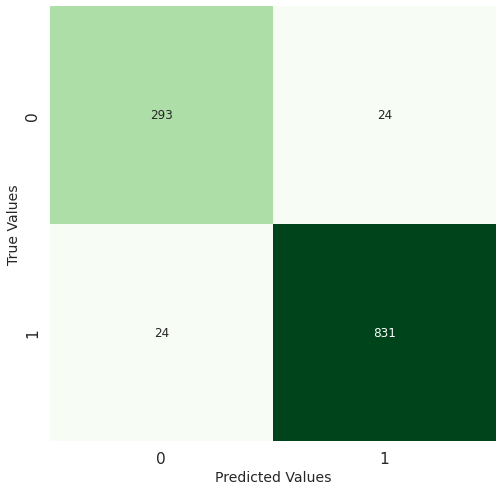

Metrics
Accuracy: 95.90%
Recall: 97.19%
Specificity: 92.43%
False Negative Rate: 2.81%

 Model 2
37/37 [==============================] - 8s 214ms/step


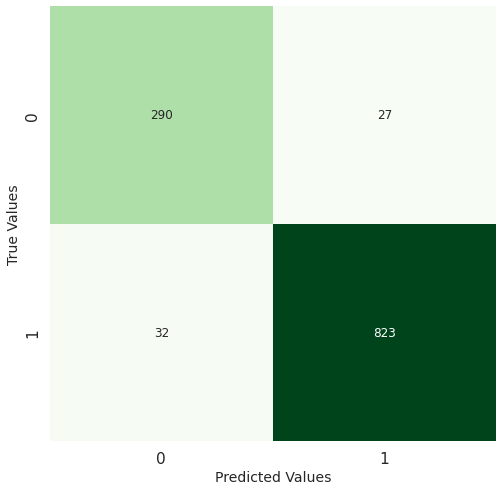

Metrics
Accuracy: 94.97%
Recall: 96.26%
Specificity: 91.48%
False Negative Rate: 3.74%

 Model 3
37/37 [==============================] - 8s 225ms/step


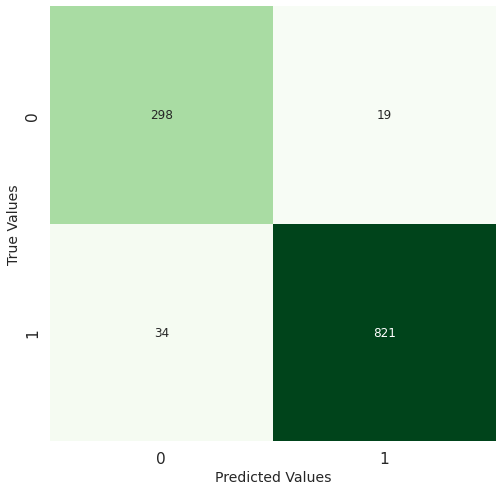

Metrics
Accuracy: 95.48%
Recall: 96.02%
Specificity: 94.01%
False Negative Rate: 3.98%

 Model 4


37/37 [==============================] - 12s 305ms/step


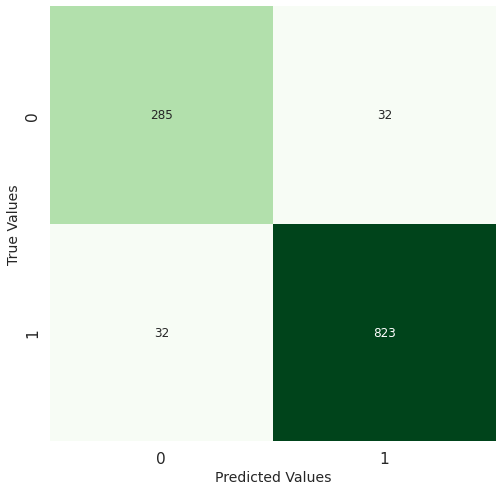

Metrics
Accuracy: 94.54%
Recall: 96.26%
Specificity: 89.91%
False Negative Rate: 3.74%

 Model 5
37/37 [==============================] - 164s 4s/step


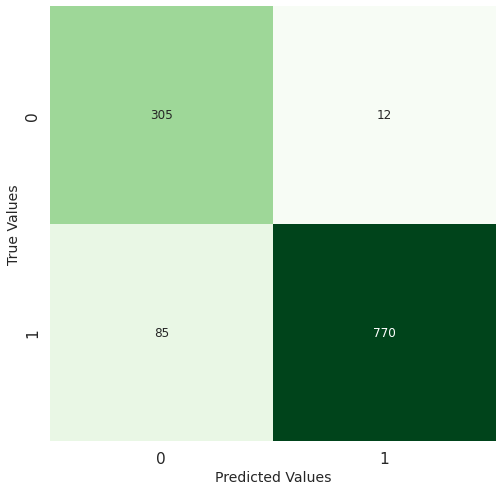

Metrics
Accuracy: 91.72%
Recall: 90.06%
Specificity: 96.21%
False Negative Rate: 9.94%


In [135]:
print(f'Model 1')
confusion_matrix_plot(test_ds, model_baseline, 'model1_test_cm')
print(f'\n Model 2')
confusion_matrix_plot(test_ds, model2, 'model2_test_cm')
print(f'\n Model 3')
confusion_matrix_plot(test_ds, model3, 'model3_test_cm')
print(f'\n Model 4')
confusion_matrix_plot(test_ds, model4, 'model4_test_cm')
print(f'\n Model 5')
confusion_matrix_plot(test_ds, model5, 'model5_test_cm')

## Evaluation Discussion
According to the analysis on the testing data, Models 5 is the worse model as it has a false negative rate at almost 10%, twice the limit that I had set to select a model. Models 2, 3, and 4 have similar metrics for the testing data but they were not as good as model 1.

Model 1 is the baseline model and contains only a single convolutional neural network with max pooling. It is likely that there is not enought data to support adding more layers. Adding more layers to the neural network may have too many connections between the layers and result in more inaccurate information and confusion in what is actually happening.

## Deployment
To solve the business problem, an application must be devloped to deploy the model for healthcare providers can use to classify a chest x-ray as 'normal' or with 'pneumonia'. Using `tensorflow` and `keras` I can load a chest x-ray image and convert that to a tensor. That tensor is inputted into the model where the results will be 'normal' or 'pneumonia' classification.

The pneumonia classificaiton app prototype is deployed using [Steamlit](https://kjspring-x-ray-pneumonia-prediction-app-app-bmt24r.streamlit.app/).

In [69]:
def predict_pneumonia(img_source, model):
    from tensorflow.keras.utils import load_img, img_to_array
    from tensorflow import keras
    import numpy as np
    
    # Load the model from the file
    model = keras.models.load_model(model)
    
    # Load the image
    img = load_img(img_source,
                   color_mode='grayscale',
                   target_size=(240,240))
    
    # Construct the tensor that .predict is expecting
    #img = load_img(img_source, target_size=(64, 64))
    img = img_to_array(img)
    data = np.expand_dims(img, axis=0)#/255
    #print(data)
    
    # get the prediction and return
    prediction = model.predict(data, verbose=0)
    if prediction < 0.5:
        print('Predict: normal chest x-ray')
    else:
        print('Predict: pneumonia chest x-ray')
    #print(prediction)
    return prediction # return position of the highest probability

In [136]:
# Test Prediction
# Baseline Model
model_src = 'models/keras/baseline_model.keras'

print('M1: Baseline Model')
print('Training Data normal x-ray')
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train normal data

print('\nTraining Data pneumonia x-ray')
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # train pneumonia data

print('\nnormal x-ray from web')
predict_pneumonia('img/app_img.jpeg', model_src) # normal x-ray from web

print('\nPneumonia x-ray from web')
predict_pneumonia('img/app_img_pneumonia.jpg', model_src) # pneumonia x-ray from web

M1: Baseline Model
Training Data normal x-ray
Predict: normal chest x-ray

Training Data pneumonia x-ray
Predict: pneumonia chest x-ray

normal x-ray from web
Predict: pneumonia chest x-ray

Pneumonia x-ray from web
Predict: pneumonia chest x-ray


array([[0.9582275]], dtype=float32)

In [137]:
# Test Prediction
# Model 2
model_src = 'models/keras/model2.keras'

print('M2: Three layer CNN')
print('Training Data normal x-ray')
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train normal data

print('\nTraining Data pneumonia x-ray')
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # train pneumonia data

print('\nNormal x-ray from web')
predict_pneumonia('img/app_img.jpeg', model_src) # normal x-ray from web

print('\nPneumonia x-ray from web')
predict_pneumonia('img/app_img_pneumonia.jpg', model_src) # pneumonia x-ray from web

M2: Three layer CNN
Training Data normal x-ray
Predict: normal chest x-ray

Training Data pneumonia x-ray
Predict: pneumonia chest x-ray

Normal x-ray from web
Predict: pneumonia chest x-ray

Pneumonia x-ray from web
Predict: pneumonia chest x-ray


array([[0.96997434]], dtype=float32)

In [138]:
# Test Prediction
# Baseline Model
model_src = 'models/keras/model3.keras'

print('M3: With Dropout')
print('Training Data normal x-ray')
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train normal data

print('\nTraining Data pneumonia x-ray')
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # train pneumonia data

print('\nNormal x-ray from web')
predict_pneumonia('img/app_img.jpeg', model_src) # normal x-ray from web

print('\nPneumonia x-ray from web')
predict_pneumonia('img/app_img_pneumonia.jpg', model_src) # pneumonia x-ray from web

M3: With Dropout
Training Data normal x-ray
Predict: normal chest x-ray

Training Data pneumonia x-ray
Predict: pneumonia chest x-ray

Normal x-ray from web
Predict: pneumonia chest x-ray

Pneumonia x-ray from web
Predict: pneumonia chest x-ray


array([[0.9461871]], dtype=float32)

In [139]:
# Test Prediction
# Model 4
model_src = 'models/keras/model4.keras'

print('M4: Data Augmentation')
print('Training Data normal x-ray')
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train normal data

print('\nTraining Data pneumonia x-ray')
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # train pneumonia data

print('\nNormal x-ray from web')
predict_pneumonia('img/app_img.jpeg', model_src) # normal x-ray from web

print('\nPneumonia x-ray from web')
predict_pneumonia('img/app_img_pneumonia.jpg', model_src) # pneumonia x-ray from web

M4: Data Augmentation
Training Data normal x-ray


Predict: normal chest x-ray

Training Data pneumonia x-ray


Predict: pneumonia chest x-ray

Normal x-ray from web


Predict: pneumonia chest x-ray

Pneumonia x-ray from web


Predict: normal chest x-ray


array([[0.22776747]], dtype=float32)

In [140]:
# Test Prediction
# Model 5
model_src = 'models/keras/m5.keras'

print('M5: Transfer Learning')
print('Training Data normal x-ray')
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train normal data

print('\nTraining Data pneumonia x-ray')
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # train pneumonia data

print('\nNormal x-ray from web')
predict_pneumonia('img/app_img.jpeg', model_src) # normal x-ray from web

print('\nPneumonia x-ray from web')
predict_pneumonia('img/app_img_pneumonia.jpg', model_src) # pneumonia x-ray from web

M5: Transfer Learning
Training Data normal x-ray
Predict: normal chest x-ray

Training Data pneumonia x-ray
Predict: pneumonia chest x-ray

Normal x-ray from web
Predict: normal chest x-ray

Pneumonia x-ray from web
Predict: pneumonia chest x-ray


array([[0.8275812]], dtype=float32)

## Prediction Function discussion
To test the prediction function I included data from the training dataset and data of normal and pneumonia x-rays found through Google image search.

According to this small test model 5 was the best as it is able to distinguish images with and without pneumonia. The baseline model, model 2, and model 3 classifies all these images as having pneumonia except the normal X-ray in the training data. Model 4 fails to correctly classify the normal and pneumonia x-ray downloaded from the internet but does correctly classify the training images included in this test.

This test shows that the prediction function works as expected but the models do give suprising results when introduced to data that is outside the provided data package. Models 1-4 may not perform correctly in a production environment and their metrics may be lower than what was identified through the testind data.

# Conclusions and Recommendations
The five models built for this analysis all did very well in accuracy, specificity, recall, and false negative rate (FNR). Accuracy is the ability to correctly predict pneumonia and normal cases out of all the classifications. Recall is the ability for a model to accuratly classify the positive case (pneumonia). Specificity is the probability that an actual normal x-ray will be classified as normal.

The best model according to validation and testing metrics is model 1. It had the highest values for accuracy, specificity, recall, and false negative rate. This is a simple convolutional neural network that has one layer convolutional layer and max pooling layer. The decay in the evaluation metrics from a simple CNN to more comlex ones was suprising. The reason this did better versus the other more complex models may be due to the limited amount of images in the dataset. As more layers are added to the model the more complexity and detail that the neural network would be able to process. The higher amount of connections between the layers may result in more innacurate information and overfitting.

Althought model 5 had the worse testing metrics compared to the other models, my small test with the prediction function indicates that model 5 with images downloaded from Google Image Search may be the best choice for use in the Pneumonia Classification Application. This is because it was able to correctly classify these images while model 1 classified both the normal and pneumonia images as pneumonia. It would be beneficial to do A/B testing to compare model 5 with model 1 in beta testing of the Pneumonia Classification Application. Doing this we can determine which model is better and improve that model by including this new data in subsequent training data.


## Recommendatons
* Deploy the Pneumonia Classificaiton Application with our healthcare partners
* Use A/B testing with model 1 and 5 in beta testing of Pneumonia Classification App
* Allow application users to leave feedback on the actual diagnosis of the patient
* Accumulate this extra data to improve the classification model